2024-01-08 11:25:44.625654: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-08 11:25:44.760684: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 11:25:44.760728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 11:25:44.782677: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 11:25:44.827938: I tensorflow/core/platform/cpu_feature_guar

file sizes in directory /home/peet/plc
20230815_152435.tiff 5.16 GB
20230815_095623.tiff 3.69 GB
20230815_142150.tiff 4.01 GB
20230815_151216.tiff 6.89 GB
20230815_145608.tiff 5.83 GB
20230817_131517.tiff 4.55 GB
20230817_131150.tiff 3.93 GB
class label of /home/peet/plc/20230815_152435.tiff: no label (inference), wsi_name label: 20230815_152435
class label of /home/peet/plc/20230815_095623.tiff: no label (inference), wsi_name label: 20230815_095623
class label of /home/peet/plc/20230815_142150.tiff: no label (inference), wsi_name label: 20230815_142150
class label of /home/peet/plc/20230815_151216.tiff: no label (inference), wsi_name label: 20230815_151216
class label of /home/peet/plc/20230815_145608.tiff: no label (inference), wsi_name label: 20230815_145608
class label of /home/peet/plc/20230817_131517.tiff: no label (inference), wsi_name label: 20230817_131517
class label of /home/peet/plc/20230817_131150.tiff: no label (inference), wsi_name label: 20230817_131150
Read 7 wsi image

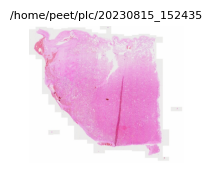

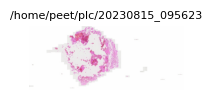

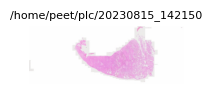

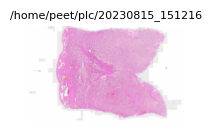

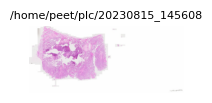

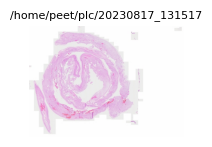

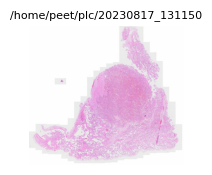

In [1]:
##########################################################################################################
# Author: Mihaly Sulyok & Peter Karacsonyi                                                               #
# Last updated: 2024 jan 8                                                                               #
# This workbook does wsi preprocessing with Pathml version 2.1.1                                         #
# Input: wsi image files, tested with OpenSlide .tif                                                     #
# Transformations: TissueDetectionHE                                                                     #
# Output: h5path files (https://pathml.readthedocs.io/en/latest/h5path.html)                             #
##########################################################################################################

# local imports
import lib
import os
if os.name == 'nt':
    import helpers.openslideimport #on windows, openslide needs to be installed manually, check local openslideimport.py

# global imports
import time
import shutil
from pathlib import Path
import matplotlib.pyplot as plt

# pathml imports
from pathml import types
from pathml.core import SlideData, SlideDataset
from pathml.preprocessing import Pipeline, TissueDetectionHE

#####################
# configure folders #
#####################
# where are our slides?
wsi_dir = Path("/home/peet/plc")
# output h5path files to (will be created)
h5_dir = Path("/mnt/bigdata/plc/h5")
h5_dir.mkdir(0o644, parents=True, exist_ok=True)
# tissues with endpoints have this substring in their filename
endpoint_filename = "a"
# disable for inference
attach_class_labels = False

#######################################
# configure transformation parameters #
#######################################
pipeline = Pipeline([
    # best values found for placenta wsis
    TissueDetectionHE(
        mask_name = "tissue", 
        threshold = 19,
        min_region_size=1000,
        outer_contours_only=False,
        max_hole_size = 10000,
        use_saturation=True
    )
])

wsi_paths = list(wsi_dir.glob("*.tif*"))
lib.print_file_sizes(wsi_dir)
wsi_list = []
label = {}
label_class = None
label_wsi_name = None
for wsi in wsi_paths:
    label_wsi_name = wsi.name.lower().split(".")[0]
    if attach_class_labels:
        # set class label based on filename
        if endpoint_filename in wsi.name.lower():
            label_class = 1
        else: 
            label_class = 0
        
        print(f"class label of {wsi}: {label_class}, wsi_name label: {label_wsi_name}")
        wsi_list.append(
            SlideData(
                str(wsi), 
                name = str(wsi).split(".")[0], 
                backend = "openslide", 
                slide_type = types.HE,
                labels = {
                    "class": label_class,
                    "wsi_name": label_wsi_name,   
                }
            )
        )
    else:
        wsi_list.append(
            SlideData(
                str(wsi), 
                name = str(wsi).split(".")[0], 
                backend = "openslide", 
                slide_type = types.HE,
                labels = {
                    "wsi_name": label_wsi_name,   
                }
            )
        )
        print(f"class label of {wsi}: no label (inference), wsi_name label: {label_wsi_name}")

slide_dataset = SlideDataset(wsi_list)

# Draw images
print(f"Read {len(slide_dataset)} wsi images: ")
for slide in slide_dataset:
    _, axs = plt.subplots(figsize=(2, 2))
    slide.plot(ax=axs)
    axs.set_title(label=slide.name, fontsize=8)

In [2]:
# run preprocessing pipeline
start_time = time.time()

for slide in slide_dataset:
    slide.run(
        pipeline,
        tile_size=500, # https://www.sciencedirect.com/science/article/pii/S2352914822000053
        # tile_stride (int, optional) – Pixels of overlap between tiles
        # tile_pad (bool) – How to handle chunks on the edges.
        level = 0,
        distributed=False, # windows OpenSlide DLL error can be fixed by importing into core.py
        overwrite_existing_tiles=True,
        write_dir=str(h5_dir),
    )
    print(f"pipeline completed for {slide.name}, extracting {len(slide.tiles.keys)} tiles")
    # move h5path file(s) to h5 dir manually because run.write_dir is buggy
    h5_paths = list(wsi_dir.glob("*.h5path"))
    for h5file in h5_paths:
        shutil.move(str(h5file), str(h5_dir / h5file.name))
        print(f"slide {slide.name} moved to {h5_dir/h5file.name}")

print(f"Total number of tiles extracted: {sum(len(slide.tiles.keys) for slide in slide_dataset.slides)}")

lib.print_file_sizes(h5_dir)
time_elapsed = time.time() - start_time
print('Preprocessing completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

pipeline completed for /home/peet/plc/20230815_152435, extracting 32448 tiles


OSError: [Errno 18] Invalid cross-device link: '/home/peet/plc/20230815_152435.h5path' -> '/mnt/bigdata/plc/h5/20230815_152435.h5path'